In [36]:
import os
import pickle
import torch
import nb_utils
from lightning_data_modules import HaarDecomposedDataset, ImageDatasets, PairedDataset, SyntheticDataset, SyntheticPairedDataset, Synthetic1DConditionalDataset, SyntheticTimeSeries, SRDataset, SRFLOWDataset, KSphereDataset, MammothDataset, LineDataset, GanDataset #needed for datamodule registration
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.KSphereGroundTruthModel import KSphereGroundTruthModel
from models.ksphere_gt import KSphereGT
from models.ddpm import DDPM
from models.fcn import FCN
import pickle
import sde_lib
from dim_reduction import get_manifold_dimension

In [37]:
config_path ='logs/ksphere/robustness/std=0.0/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
#config.model.checkpoint_path = $os.path.join(log_path, log_name, "checkpoints/best/last.ckpt")
config.model.checkpoint_path = 'logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt'

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
config.training.batch_size=32
config.dim_estimation.num_datapoints=5

In [38]:
import torch 
from pathlib import Path
import os
from lightning_modules.utils import create_lightning_module
from lightning_data_modules.utils import create_lightning_datamodule
from models import utils as mutils
import math
from tqdm import tqdm
import pickle

#---- create the setup ---
def robust(config, noise=0):
  log_path = config.logging.log_path
  log_name = config.logging.log_name
  save_path = os.path.join(log_path, log_name, 'svd')
  Path(save_path).mkdir(parents=True, exist_ok=True)

  DataModule = create_lightning_datamodule(config)
  DataModule.setup()
  train_dataloader = DataModule.train_dataloader()
    
  pl_module = create_lightning_module(config)
  pl_module = pl_module.load_from_checkpoint(config.model.checkpoint_path)
  pl_module.configure_sde(config)

  #get the ema parameters for evaluation
  #pl_module.ema.store(pl_module.parameters())
  #pl_module.ema.copy_to(pl_module.parameters()) 

  device = config.device
  pl_module = pl_module.to(device)
  pl_module.eval()
  
  score_model = pl_module.score_model
  sde = pl_module.sde
  score_fn = mutils.get_score_fn(sde, score_model, conditional=False, train=False, continuous=True)
  #---- end of setup ----

  num_datapoints = 2
  singular_values = []
  normalized_scores_list = []
  idx = 0
  with tqdm(total=num_datapoints) as pbar:
    for _, orig_batch in enumerate(train_dataloader):

      orig_batch = orig_batch.to(device)
      batchsize = orig_batch.size(0)
      
      if idx+1 >= num_datapoints:
          break
        
      for x in orig_batch:
        if idx+1 >= num_datapoints:
          break
        
        ambient_dim = math.prod(x.shape[1:])
        x = x.repeat([batchsize,]+[1 for i in range(len(x.shape))])

        num_batches = ambient_dim // batchsize + 1
        extra_in_last_batch = ambient_dim - (ambient_dim // batchsize) * batchsize
        num_batches *= 8

        t = pl_module.sampling_eps
        vec_t = torch.ones(x.size(0), device=device) * t

        scores = []
        for i in range(1, num_batches+1):
          batch = x.clone()

          mean, std = sde.marginal_prob(batch, vec_t)
          z = torch.randn_like(batch)
          batch = mean + std[(...,) + (None,) * len(batch.shape[1:])] * z
          score = score_fn(batch, vec_t).detach().cpu()

          if i < num_batches:
            scores.append(score)
          else:
            scores.append(score[:extra_in_last_batch])
        
        scores = torch.cat(scores, dim=0)
        scores = torch.flatten(scores, start_dim=1)

        means = scores.mean(dim=0, keepdim=True)
        normalized_scores = scores - means
        print(normalized_scores.shape)
        #corrupt
        norm = torch.linalg.norm(normalized_scores, dim=1).mean()
        corruption = noise * norm * torch.randn_like(normalized_scores) / np.sqrt(normalized_scores.shape[1])
        corruption_norm = torch.linalg.norm(corruption, dim=1).mean()
        print(f'score norm: {norm}, corruption norm: {corruption_norm}, corruption_std: {noise * norm / np.sqrt(normalized_scores.shape[1])}')
        normalized_scores = corruption + normalized_scores
        
        #normalized_scores_list.append(normalized_scores.tolist())

        u, s, v = torch.linalg.svd(normalized_scores)
        s = s.tolist()
        singular_values.append(s)

        idx+=1
        pbar.update(1)
    return singular_values

In [39]:
stds = np.linspace(0, 1, 20)
r = []
for std in stds:
    singular_values = robust(config, noise=std)[0]
    r.append(singular_values)

Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.31it/s]

torch.Size([225, 100])
score norm: 802.3698120117188, corruption norm: 0.0, corruption_std: 0.0



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.50it/s]

torch.Size([225, 100])
score norm: 797.3857421875, corruption norm: 41.658958435058594, corruption_std: 4.1967668533325195



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.96it/s]

torch.Size([225, 100])
score norm: 790.0340576171875, corruption norm: 82.4432601928711, corruption_std: 8.31614875793457



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.52it/s]

torch.Size([225, 100])
score norm: 801.6970825195312, corruption norm: 125.84368133544922, corruption_std: 12.658374786376953



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  2.89it/s]

torch.Size([225, 100])
score norm: 801.697265625, corruption norm: 168.67930603027344, corruption_std: 16.877836227416992


 50%|█████     | 1/2 [00:00<00:00,  2.43it/s]
Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.16it/s]

torch.Size([225, 100])
score norm: 801.6181030273438, corruption norm: 210.71759033203125, corruption_std: 21.095212936401367



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  2.90it/s]

torch.Size([225, 100])
score norm: 806.4351196289062, corruption norm: 256.05108642578125, corruption_std: 25.466371536254883



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.31it/s]

torch.Size([225, 100])
score norm: 801.099853515625, corruption norm: 293.7265625, corruption_std: 29.514205932617188



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.34it/s]

torch.Size([225, 100])
score norm: 798.5929565429688, corruption norm: 334.1343688964844, corruption_std: 33.62496566772461



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.32it/s]

torch.Size([225, 100])
score norm: 801.8738403320312, corruption norm: 377.9604797363281, corruption_std: 37.983497619628906



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.63it/s]

torch.Size([225, 100])
score norm: 805.60791015625, corruption norm: 424.2107849121094, corruption_std: 42.40041732788086



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  2.99it/s]

torch.Size([225, 100])
score norm: 796.9938354492188, corruption norm: 459.4392395019531, corruption_std: 46.141746520996094



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.09it/s]

torch.Size([225, 100])
score norm: 800.0718994140625, corruption norm: 504.6558532714844, corruption_std: 50.530853271484375



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.21it/s]

torch.Size([225, 100])
score norm: 795.1027221679688, corruption norm: 539.5427856445312, corruption_std: 54.401763916015625



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.37it/s]

torch.Size([225, 100])
score norm: 806.14990234375, corruption norm: 591.05859375, corruption_std: 59.40052032470703



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.23it/s]

torch.Size([225, 100])
score norm: 812.98046875, corruption norm: 634.9800415039062, corruption_std: 64.18267059326172



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.35it/s]

torch.Size([225, 100])
score norm: 806.4051513671875, corruption norm: 678.1158447265625, corruption_std: 67.90779876708984



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.56it/s]

torch.Size([225, 100])
score norm: 794.1837768554688, corruption norm: 710.6755981445312, corruption_std: 71.05854797363281



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.43it/s]

torch.Size([225, 100])
score norm: 799.2607421875, corruption norm: 756.5604248046875, corruption_std: 75.71943664550781



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/robustness/std=0.0/checkpoints/best/last.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  3.47it/s]

torch.Size([225, 100])
score norm: 809.4193725585938, corruption norm: 808.6036987304688, corruption_std: 80.94194030761719


In [159]:
import scipy
def marcenko_pastur_median(beta, N=1000):
    beta_plus = (1 + np.sqrt(beta))**2
    beta_minus = (1 - np.sqrt(beta))**2
    r = lambda x: np.sqrt((beta_plus - x)/(x - beta_minus))
    cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))
    if beta > 1:
        indicator_small = lambda x: 1 if x < beta_minus else 0
        indicator_range = lambda x: 1 if (x >= beta_minus and x <= beta_plus) else 0
        cdf_full = lambda x: ((beta - 1)/beta)*indicator_small(x) + (((beta -1) / (2*beta)) + cdf(x)) * indicator_range(x)
    else:
        cdf_full = lambda x: cdf(x)

    xs = np.linspace(beta_minus, beta_plus, N)
    vals = np.array([cdf_full(x) for x in xs])
    return xs[(vals > 0.5)][0]

def optimal_threshold(beta):
    t = 2 * (beta + 1)
    t = t + (8 * beta) /((beta + 1) + np.sqrt(beta**2 + 14* beta + 1))
    t = np.sqrt(t)
    return t


In [160]:
m = marcenko_pastur_median(2.25)

/tmp/ipykernel_292924/194083641.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  r = lambda x: np.sqrt((beta_plus - x)/(x - beta_minus))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))


In [165]:
m = marcenko_pastur_median(2.25)
np.median(r[0]) / np.sqrt(225 * m)

/tmp/ipykernel_292924/194083641.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  r = lambda x: np.sqrt((beta_plus - x)/(x - beta_minus))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))
/tmp/ipykernel_292924/194083641.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  cdf = lambda x: (1 / (2*np.pi * beta)) * (np.pi*beta + np.sqrt((beta_plus - x)*(x - beta_minus)) - (1+beta)*np.arctan((r(x)**2 - 1)/(2*r(x))) + (1-beta)*np.arctan((beta_minus*r(x)**2 - beta_plus) / (2*(1-beta)*r(x))))


144.8457384693562

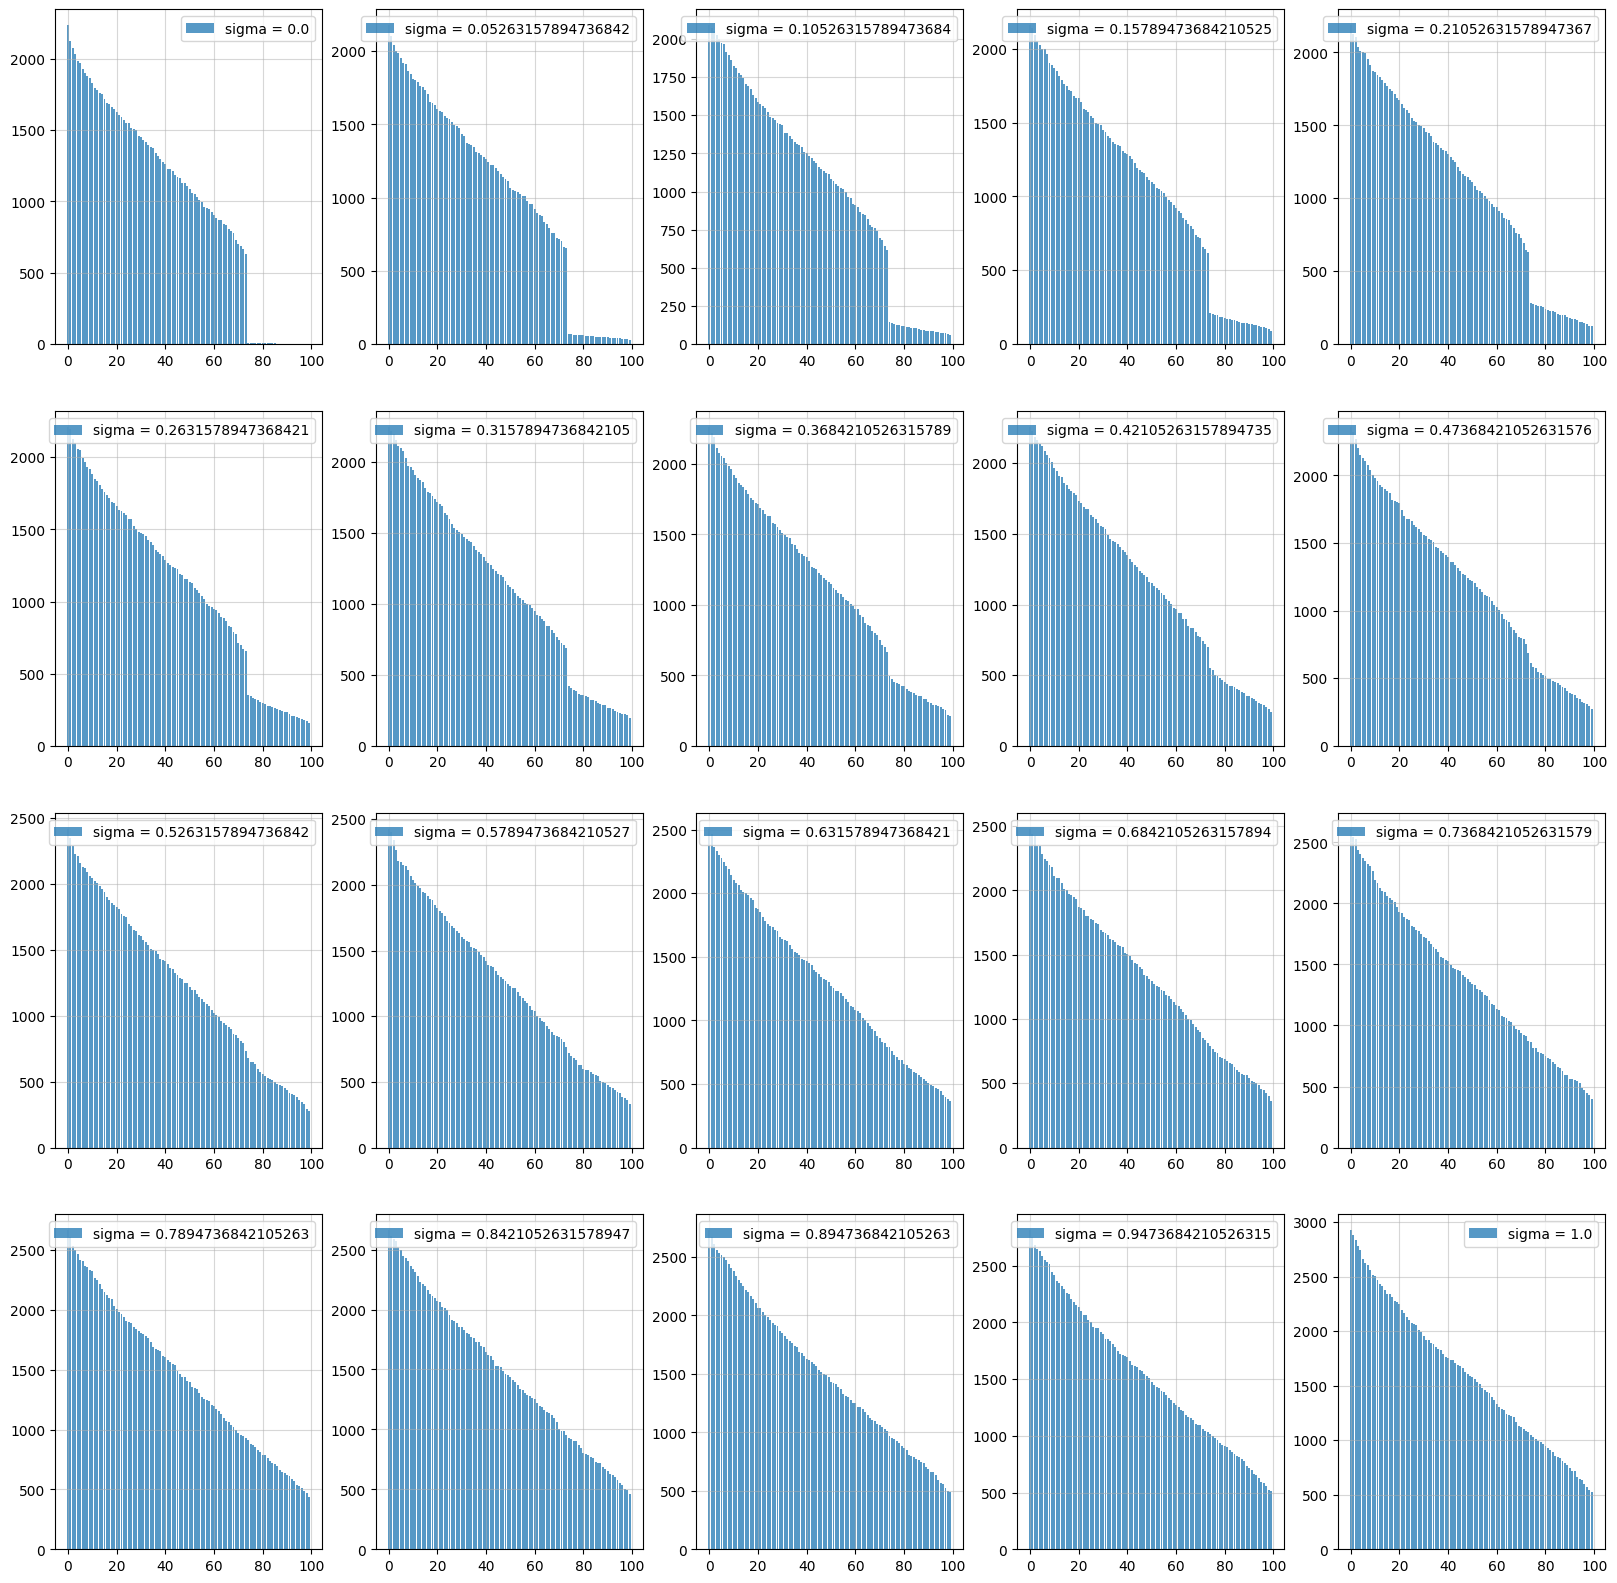

In [43]:
fig, axes = plt.subplots(4, 5,figsize=(20,20))
axes = axes.flatten()
#ax.rcParams.update({'font.size': 16})

for i, (std, s) in enumerate(zip(stds, r)):
    axes[i].grid(alpha=0.5)
    axes[i].bar(range(len(s)), s, label=f'sigma = {std}', alpha=0.75)
    axes[i].legend()
#plt.xticks(range(0, 100, 5))
#plt.vlines(95, 0, np.max(s), color='r', linestyles='--')
#plt.vlines(70, 0, np.max(s), color='r', linestyles='--')
fig.show()

In [14]:
def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference

In [15]:
dims = []
for i, (std, s) in enumerate(zip(stds, r)):
    norm_factor = s[1]-s[2]
    diff = [(s[i]-s[i+1])/norm_factor for i in range(1, len(s)-1)]
    soft = softmax(diff)
    dims.append(len(soft) - soft.argmax())

In [16]:
dims

[51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 97,
 75,
 89,
 97,
 97,
 93,
 92]

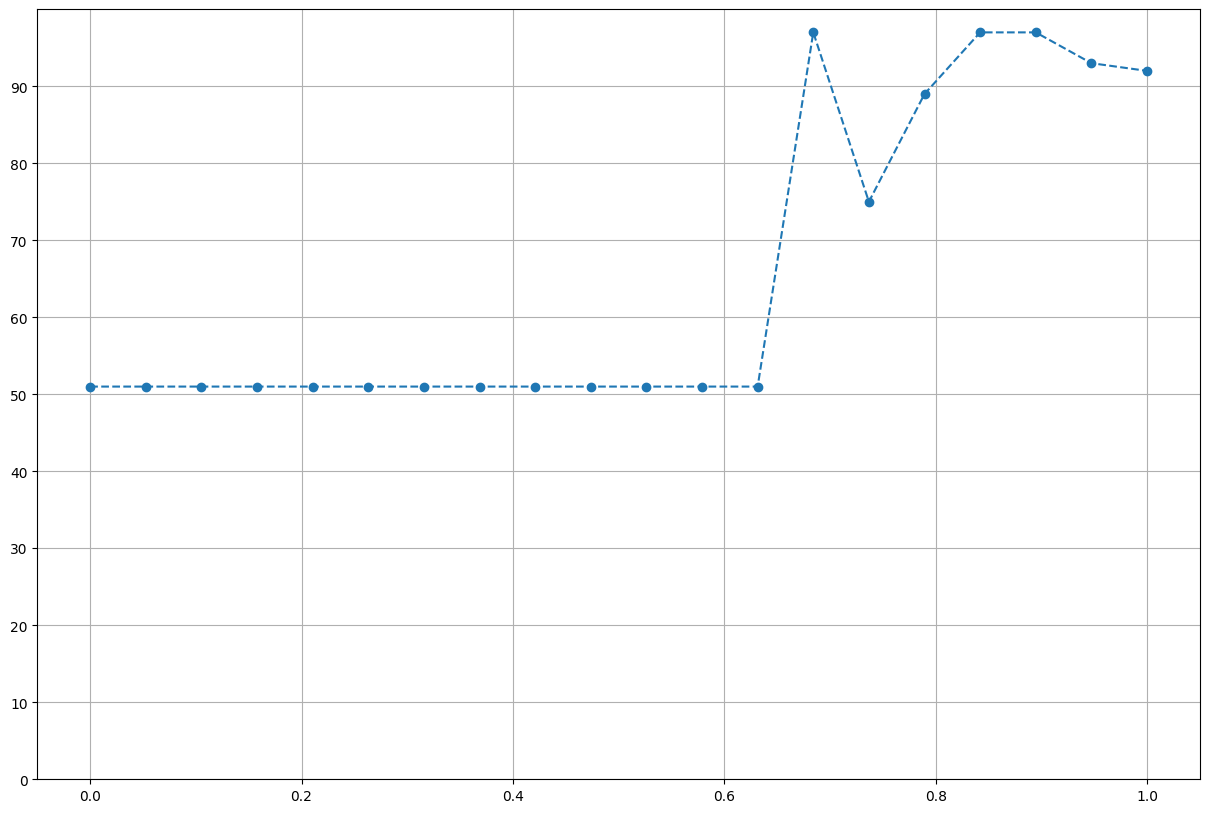

In [19]:
plt.figure(figsize=(15,10))
plt.plot(stds, dims, 'o--')
plt.ylim(0,100)
plt.yticks(range(0,100,10))
plt.grid()